<a href="https://colab.research.google.com/github/prudhvirajboddu/TensorFlowML/blob/master/MelanomaX512EB7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q efficientnet

In [2]:
import pandas as pd
import re
import math
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras import *
from tensorflow.keras.layers import *
#from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold,StratifiedKFold
import efficientnet.tfkeras as tfn
from tensorflow.keras import backend as K
#gcs_path=KaggleDatasets().get_gcs_path('512x512-melanoma-tfrecords-70k-images')
#print(gcs_path)

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.15.25.186:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.15.25.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.15.25.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [4]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_PATH = "gs://kds-c0f584f88a8cdde1136ca711521457434b79af09b9027cba5008e09e"

folds=5

# Configuration
EPOCHS = 30

BATCH_SIZE = 32 * strategy.num_replicas_in_sync

IMAGE_SIZE = [512 , 512]
# Seed
SEED = 123
# Learning rate
LR = 0.0004
# training filenames directory
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
# test filenames directory
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')
# submission file
#SUB = pd.read_csv(GCS_PATH+'/sample_submission.csv')

In [5]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transform(image, label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    tmp = random.uniform(0, 1)
    if 0 < tmp <= 0.1:
        rot = 15.0 * tf.random.normal([1],dtype='float32')
    elif 0.1 < tmp <= 0.2:
        rot = 30.0 * tf.random.normal([1],dtype='float32')
    elif 0.2 < tmp <= 0.3:
        rot = 45.0 * tf.random.normal([1],dtype='float32')
    elif 0.3 < tmp <= 0.4:
        rot = 60.0 * tf.random.normal([1],dtype='float32')
    elif 0.4 < tmp <= 0.5:
        rot = 75.0 * tf.random.normal([1],dtype='float32')
    elif 0.5 < tmp <= 0.6:
        rot = 90.0 * tf.random.normal([1],dtype='float32')
    elif 0.6 < tmp <= 0.7:
        rot = 110.0 * tf.random.normal([1],dtype='float32')
    elif 0.7 < tmp <= 0.8:
        rot = 130.0 * tf.random.normal([1],dtype='float32')
    elif 0.8 < tmp <= 0.9:
        rot = 150.0 * tf.random.normal([1],dtype='float32')
    elif 0.9 < tmp <= 1.0:
        rot = 180.0 * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]), label

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.bfloat16) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['target'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image,0.02)
    image = tf.image.random_contrast(image,0.8,1.1)
    image = tf.image.random_brightness(image,0.1)
    image = tf.image.random_saturation(image, 0.7, 1.4)
    return image, label  

def get_training_dataset(TRAINING_FILENAMES):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(VALIDATION_FILENAMES):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True)
    #dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(TEST_FILENAMES,ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def read_tfrecord_full(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "image_name": tf.io.FixedLenFeature([], tf.string), 
        "target": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    image_name = example['image_name']
    target = tf.cast(example['target'], tf.int32)

    return image, image_name, target


def load_dataset_full(filenames):        
    # automatically interleaves reads from multiple files
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    # returns a dataset of (image_name, target)
    dataset = dataset.map(read_tfrecord_full, num_parallel_calls = AUTO) 
    return dataset

def get_data_full(filenames):
    dataset = load_dataset_full(filenames)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = int(count_data_items(TRAINING_FILENAMES) * 0.8)
NUM_VALIDATION_IMAGES = int(count_data_items(TRAINING_FILENAMES) * 0.2)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALIDATION_STEPS= NUM_VALIDATION_IMAGES // BATCH_SIZE
print('Dataset: {} training images ,{} Validation images,{} unlabeled test images'.format(NUM_TRAINING_IMAGES,NUM_VALIDATION_IMAGES,NUM_TEST_IMAGES))
print("STEPS_PER_EPOCH are {}".format(STEPS_PER_EPOCH))
print("VALIDATION_STEPS are {}".format(VALIDATION_STEPS))

Dataset: 48389 training images ,12097 Validation images,10982 unlabeled test images
STEPS_PER_EPOCH are 189
VALIDATION_STEPS are 47


In [7]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [8]:
def create_model():
    with strategy.scope():
        inp1=Input(shape=(*IMAGE_SIZE,3))
        eb6=tfn.EfficientNetB6(include_top=False,input_shape=(*IMAGE_SIZE,3),weights='imagenet')
        eb6.trainable=False
        x=eb6(inp1,training=False)
        x=GlobalAveragePooling2D()(x)
        x=Dense(512,activation='relu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.2)(x)
        x=Dense(182,activation='relu')(x)
        x=BatchNormalization()(x)
        x=Dropout(0.2)(x)
        Y=Dense(1,activation='sigmoid')(x)
        model=Model(inp1,Y)
        model.compile(optimizer=optimizers.Adam(lr=LR),
                      loss=[binary_focal_loss(gamma=2., alpha=.8)],
                      metrics=[metrics.BinaryAccuracy(),metrics.AUC()]
                     )
        return model

In [9]:
def get_cb():
    return [
        tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_auc', 
                                             factor = 0.4, patience = 2, verbose = 1,
                                             min_delta = 0.0001, mode = 'max'),
        tf.keras.callbacks.EarlyStopping(monitor = 'val_auc', mode = 'ma  x', patience = 4, 
                                        verbose = 1, min_delta = 0.0001, restore_best_weights = True)
    ]

In [10]:
import matplotlib.pyplot as plt
def display_training_curves(training, validation, title, subplot):
    """
    Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
    """
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [11]:
models=[]
oof_image_name = []
oof_target = []
oof_prediction = []
kfold = KFold(5, shuffle = True, random_state = SEED)
for fold, (trn_ind, val_ind) in enumerate(kfold.split(TRAINING_FILENAMES)):
    print("\n")
    print('_'*50)
    print(f'Training fold {fold + 1}')
    train_dataset = get_training_dataset([TRAINING_FILENAMES[x] for x in trn_ind])
    val_dataset = get_validation_dataset([TRAINING_FILENAMES[x] for x in val_ind])
    K.clear_session()
    model=create_model()
    history=model.fit(train_dataset,
              epochs=EPOCHS,
              steps_per_epoch=STEPS_PER_EPOCH,
              validation_data=val_dataset,
              validation_steps=VALIDATION_STEPS,
              callbacks=get_cb()
             )
    models.append(model)
 # want to predict the validation set and save them for stacking
    number_of_files = count_data_items([TRAINING_FILENAMES[x] for x in val_ind])
    dataset = get_data_full([TRAINING_FILENAMES[x] for x in val_ind])
        # get the image name
    image_name = dataset.map(lambda image, image_name, target: image_name).unbatch()
    image_name = next(iter(image_name.batch(number_of_files))).numpy().astype('U')
        # get the real target
    target = dataset.map(lambda image, image_name, target: target).unbatch()
    target = next(iter(target.batch(number_of_files))).numpy()
        # predict the validation set
    image = dataset.map(lambda image, image_name, target: image)
    probabilities = model.predict(image)
    oof_image_name.extend(list(image_name))
    oof_target.extend(list(target))
    oof_prediction.extend(list(np.concatenate(probabilities)))



__________________________________________________
Training fold 1
165527552/165527152 [==============================] - 2s 0us/step
Epoch 1/30
189/189 [==============================] - 188s 996ms/step - binary_accuracy: 0.7062 - auc: 0.7325 - loss: 1.7743 - val_binary_accuracy: 0.9156 - val_auc: 0.8498 - val_loss: 0.9806 - lr: 4.0000e-04
Epoch 2/30
189/189 [==============================] - 159s 842ms/step - binary_accuracy: 0.8094 - auc: 0.7941 - loss: 1.1986 - val_binary_accuracy: 0.8812 - val_auc: 0.8675 - val_loss: 0.8436 - lr: 4.0000e-04
Epoch 3/30
189/189 [==============================] - 157s 829ms/step - binary_accuracy: 0.8328 - auc: 0.8242 - loss: 1.0509 - val_binary_accuracy: 0.8398 - val_auc: 0.8754 - val_loss: 0.8427 - lr: 4.0000e-04
Epoch 4/30
189/189 [==============================] - 152s 804ms/step - binary_accuracy: 0.8414 - auc: 0.8377 - loss: 0.9842 - val_binary_accuracy: 0.8815 - val_auc: 0.8718 - val_loss: 0.8690 - lr: 4.0000e-04
Epoch 5/30
189/189 [========

In [15]:
test_ds = get_test_dataset(TEST_FILENAMES ,ordered = True)
test_images_ds = test_ds.map(lambda image, image_name: image)
print('Computing predictions...')
probabilities = np.average([np.concatenate(models[i].predict(test_images_ds)) for i in range(folds)], axis = 0)
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, image_name: image_name).unbatch()
    # all in one batch
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
pred_df = pd.DataFrame({'image_name': test_ids, 'target': probabilities})
pred_df.to_csv("sub.csv",index=False)

Computing predictions...
Generating submission.csv file...


In [14]:
from google.colab import files
files.download('/content/sub.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

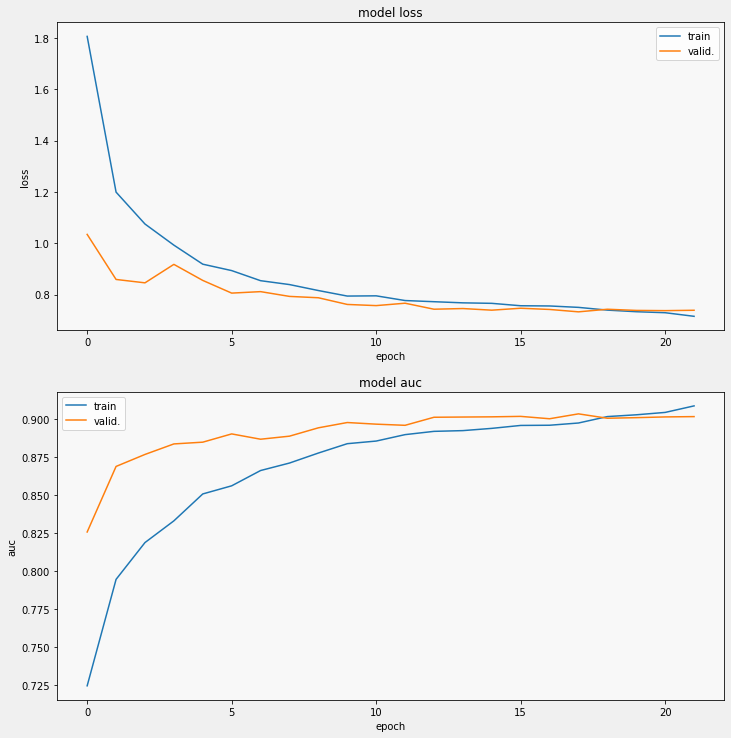

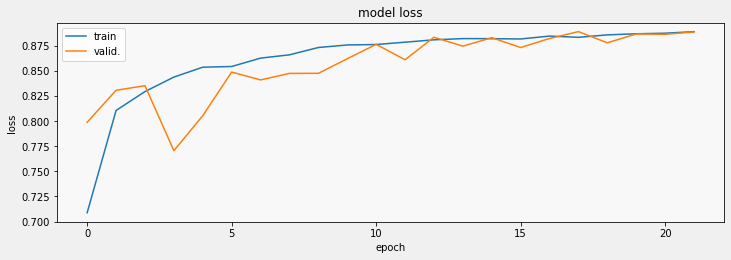

In [17]:
display_training_curves(history.history['loss'],
                        history.history['val_loss'],
                        'loss',211
                        )
display_training_curves(history.history['auc'],
                        history.history['val_auc'],
                        'auc',212
                        )
display_training_curves(history.history['binary_accuracy'],
                        history.history['val_binary_accuracy'],
                        'loss',311
                        )

# Got 84% Accuracy After submission
